Switching off AC


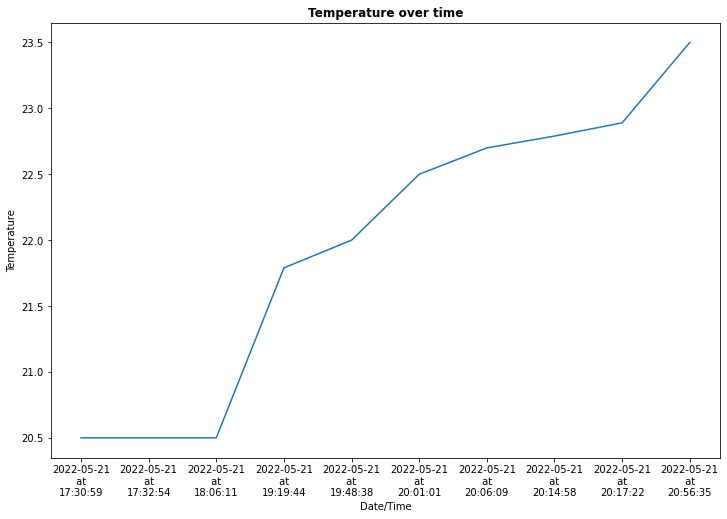

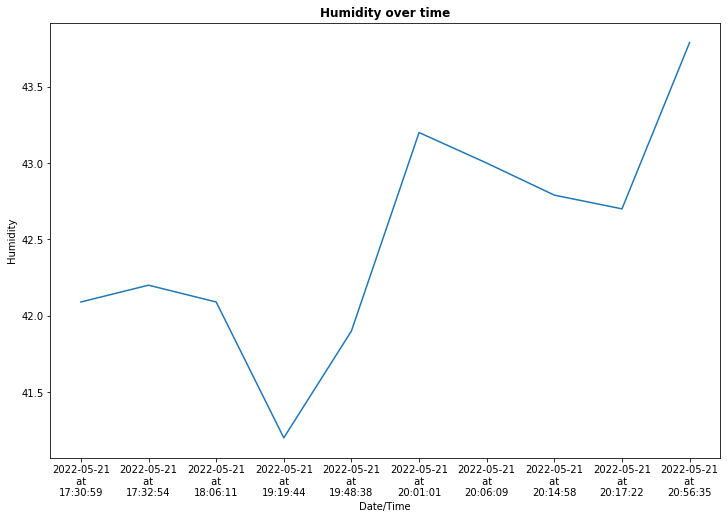

predicted: 21.790002471645092   expected: 22.0
predicted: 22.027250976835543   expected: 22.5
predicted: 22.589655452888717   expected: 22.7
predicted: 22.741626140785666   expected: 22.79
predicted: 22.809488613977376   expected: 22.89
predicted: 22.912300343607487   expected: 23.5
test: [22.0, 22.5, 22.7, 22.79, 22.89, 23.5]
pred: [21.790002471645092, 22.027250976835543, 22.589655452888717, 22.741626140785666, 22.809488613977376, 22.912300343607487]
expected: [20.5, 20.5, 20.5, 21.79, 22.0, 22.5, 22.7, 22.79, 22.89, 23.5]
RMSE = 0.325059


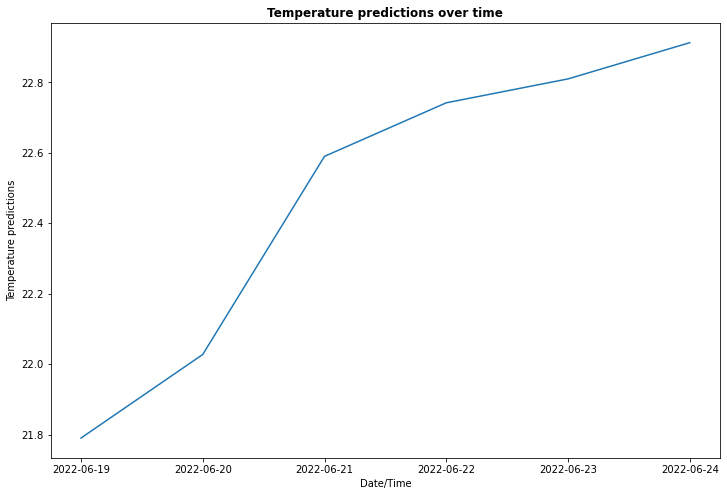

In [1]:
#Import libraries
from time import time
from tkinter import Y
import matplotlib.pyplot as plt
import http.client as httplib2
import numpy as np
import urllib
import csv
from twilio.rest import Client
import twitter

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import pandas as pd
from datetime import timedelta, date

#Function to send data to Thing Speak Cloud
def SendThingSpeak(temperature):
    key = "Z2W2ZDENXCPD3UY4"
    while True:
        temp = temperature
        params =  urllib.parse.urlencode({'field3': temp, 'key':key }) 
        headers = {"Content-typZZe": "application/x-www-form-urlencoded","Accept": "text/plain"}
        conn = httplib2.HTTPConnection("api.thingspeak.com:80")
        try:
            conn.request("POST", "/update", params, headers)
            response = conn.getresponse()
            print("Value " + temp + " sent to ThingSpeak!")
            print(response.status, response.reason)
            data = response.read()
            conn.close()
        except:
            print(" ")
        break

def sendTextMessage(text):
    account_sid = "AC0377d0ca8d0fc552668de72938e37048"
    auth_token = "714093711604a69f8288d00d0ee51fb5"
    alert = "Temperature is exceeding " + str(text) + " degrees !"
    client = Client(account_sid, auth_token)
    message = client.api.account.messages.create(to="+33778685057",from_="+15672294714",body=alert)

def sendTweet(text):
    auth = twitter.OAuth(consumer_key="aaY1e536Lp44Apytesb7ZJ9L6",
                         consumer_secret="xNgN1d9dg6U7MORfyF3ZAMOPISR2sGutZtU0K3obMK5gO1qGHB",
                         token="1485564928169857024-eEa2vMvp49B2Ej4bbCad6nVboA1q67",
                         token_secret="LkFPD43ultdOqT7tlI1v2Nslw0fDdH2Cj4uQTXsH7s1eX"
                        )
    tweet = twitter.Twitter(auth=auth)

    alert = "Temperature is exceeding " + str(text) + " degrees !"

    #Publish
    tweet.statuses.update(status=alert)

#Function to calculate average temperature
def calc_avg_temp(temperature):
    average = sum(temperature)/len(temperature)
    if(average > 32):
        print("Switching on AC")
    else:
        print("Switching off AC")

#Function to draw a graph
def drawGraph(time_values,variable,label):
    fig = plt.figure()
    plt.plot(time_values,variable)
    plt.title(label + " over time", fontweight="bold")
    plt.xlabel("Date/Time")
    plt.ylabel(label)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

#Read values from a CSV file

with open("data.csv") as d:
	reader = csv.reader(d)
	data = [ line for line in reader ]

data = np.array(data) #array containing all data

temperature = []
humidity = []
time_values = []

for i in range(1,len(data)):
    if(float(data[i][0]) > 32):
        SendThingSpeak(data[i][0])   
        sendTextMessage(data[i][0])            
        sendTweet(data[i][0])         
    temperature.append(data[i][0]) #Temperature       
    humidity.append(data[i][1])    #Humidity
    time_values.append(data[i][2] + "\n at \n" + data[i][3]) # date and time | "\n" to gain space on the x axis when I display the values on the graph

temperature = list(map(float, temperature))
humidity = list(map(float, humidity))

#Function to calculate average temperature

calc_avg_temp(temperature)

#Draw temperatures over time 
drawGraph(time_values,temperature,"Temperature")

#Draw humdidity over time
drawGraph(time_values,humidity,"Humidity")

# function AMIRA model
def arima_model(temperature):
    X = temperature
    size = int(len(X) * .44)

    train, test = X[0:size], X[size:len(X)]

    h = [x for x in train]
    pred = list()
    length = len(test)
    for value in range(length):
        model = ARIMA(h,order=(1,1,0))
        model_fit = model.fit()
        res = model_fit.forecast()
        predicted = res[0]
        pred.append(predicted)
        expected = test[value]
        h.append(expected)
        print("predicted: " + str(predicted) + "   expected: " + str(expected))

    print("test: " + str(test))
    print("pred: " + str(pred))
    print("expected: " + str(h))

    rmse = sqrt(mean_squared_error(test, pred))
    print("RMSE = " + str(round(rmse,6)))

    return(pred)

#Draw the temperature predictions on a graph

from datetime import timedelta, date
dates_values = []
predictions = arima_model(temperature)

#Starting from the day you execute the code, it predicts the temperatures for the next 7 days
for i in range(1,len(predictions)+1):
    Date_required = date.today() + timedelta(days=i)
    dates_values.append(Date_required)

drawGraph(dates_values,predictions,"Temperature predictions")
